## ライブラリのインポート

In [1]:
import random
import warnings

from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import japanize_matplotlib


random.seed(8931)
np.random.seed(8931)


warnings.simplefilter('ignore')

## 分析

### アイリスデータセット

In [2]:
iris = load_iris()

df = pd.DataFrame(iris.data, columns=[c[:-5] for c in iris.feature_names])
df['species'] = iris.target
df.loc[df['species'] == 0, 'species'] = "setosa"
df.loc[df['species'] == 1, 'species'] = "versicolor"
df.loc[df['species'] == 2, 'species'] = "virginica"

df.head(3)

,sepal length,sepal width,petal length,petal width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


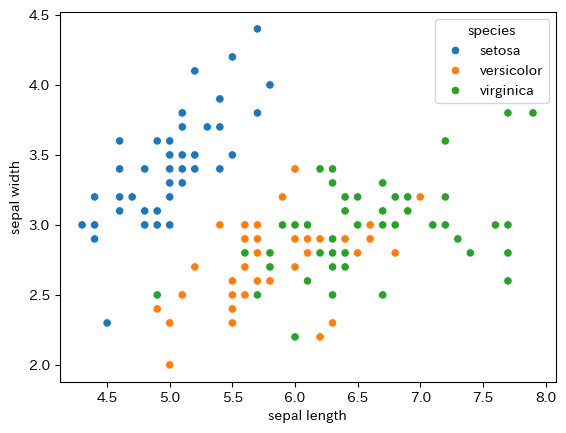

In [3]:
sns.scatterplot(df[['sepal length', 'sepal width', 'species']], x='sepal length', y='sepal width', hue='species')
plt.show()

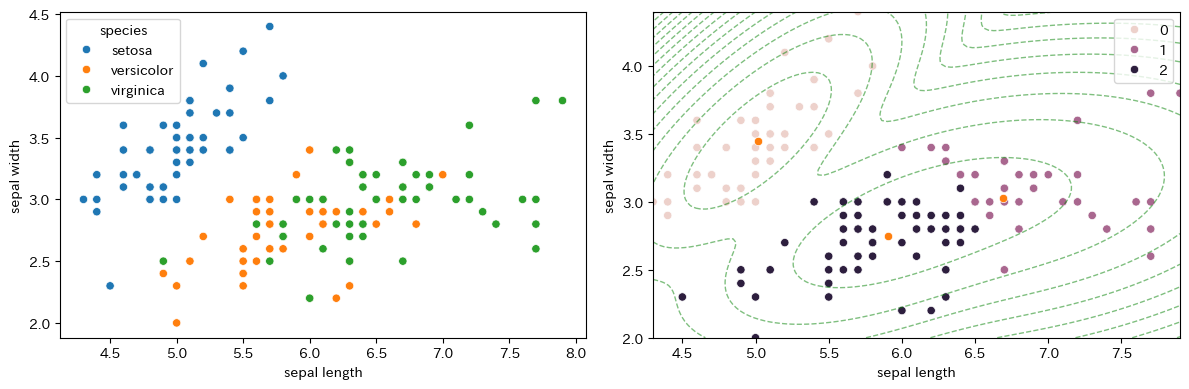

In [4]:
X = df[['sepal length', 'sepal width']]

model = GaussianMixture(n_components=3)
model.fit(X)

X_pred = X
X_pred['pred'] = model.predict(X)


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.scatterplot(df[['sepal length', 'sepal width', 'species']], x='sepal length', y='sepal width', hue='species')

plt.subplot(1, 2, 2)
sns.scatterplot(X_pred[['sepal length', 'sepal width', 'pred']], x='sepal length', y='sepal width', hue='pred')
sns.scatterplot(x=model.means_[:, 0], y=model.means_[:, 1])

x = np.linspace(X['sepal length'].min(), X['sepal length'].max(), 100)
y = np.linspace(X['sepal width'].min(), X['sepal width'].max(), 100)

x_grid, y_grid = np.meshgrid(x, y)
z = model.score_samples(np.array([x_grid.ravel(), y_grid.ravel()]).T)
z = z.reshape(x_grid.shape)
plt.contour(x_grid, y_grid, z, levels=20, linewidths=1, colors='green', linestyles='dashed', alpha=0.5)


plt.tight_layout()
plt.show()

### 擬似データでBICを計算

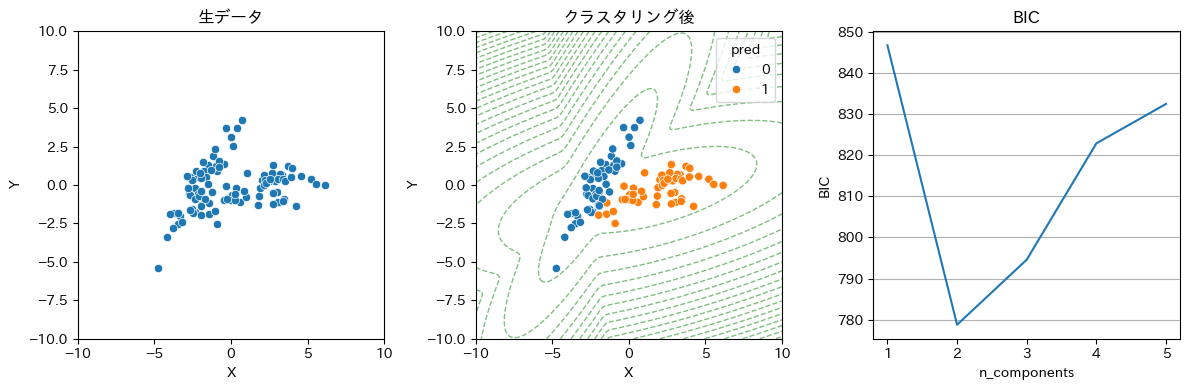

In [5]:
np.random.seed(8931)

df_randam = pd.DataFrame(np.random.multivariate_normal([-2, 0], [[1, 2], [2, 3]], 50), columns=['X', 'Y'])
df_randam['LABEL'] = 1

d = pd.DataFrame(np.random.multivariate_normal([2, 0], [[3, 1], [1, 1]], 50), columns=['X', 'Y'])
d['LABEL'] = 2
df_randam = pd.concat([df_randam, d])
df_randam.index = pd.date_range(start='2025-01-01', end='2025-04-10')

model = GaussianMixture(n_components=2)
model.fit(df_randam[['X', 'Y']].values)

df_randam_pred = df_randam[['X', 'Y']]
df_randam_pred['pred'] = model.predict(df_randam[['X', 'Y']])



plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(data=df_randam, x='X', y='Y')
plt.title('生データ')
plt.xlim(-10, 10)
plt.ylim(-10, 10)

plt.subplot(1, 3, 2)

x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
x_grid, y_grid = np.meshgrid(x, y)
z = model.score_samples(np.array([x_grid.ravel(), y_grid.ravel()]).T)
z = z.reshape(x_grid.shape)
plt.contour(x_grid, y_grid, z, levels=30, linewidths=1, colors='green', linestyles='dashed', alpha=0.5)

sns.scatterplot(data=df_randam_pred, x='X', y='Y', hue='pred')
plt.title('クラスタリング後')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.tight_layout()


bics = []

for n_components in [1, 2, 3, 4, 5]:
    model = GaussianMixture(n_components=n_components)
    model.fit(df_randam[['X', 'Y']].values)
    bics.append(round(model.bic(df_randam[['X', 'Y']]), 2))

plt.subplot(1, 3, 3)
sns.lineplot(x=[1, 2, 3, 4, 5], y=bics)
plt.title('BIC')
plt.xlabel('n_components')
plt.ylabel('BIC')
plt.grid(axis='y')
plt.show()


### GMMモジュールで擬似データセットに適用

In [6]:
def gmm_detector(df: pd.DataFrame):
    # ======================================
    # データセットの準備
    # ======================================
    max_bic = 1e16
    max_bic_n_components = None

    # ======================================
    # クラスタ数をBICで決定
    # ======================================
    for n_components in [1, 2]:    
        model = GaussianMixture(n_components=n_components)
        model.fit(df)

        if max_bic > model.bic(df):
            max_bic = model.bic(df)
            max_bic_n_components = n_components

    print('クラスタ数:', max_bic_n_components)

    if max_bic_n_components == 1:
        return 1, None
    
    # ======================================
    # 決定したクラスタ数でクラスタリング
    # ======================================
    hits = []
    model = GaussianMixture(n_components=max_bic_n_components)
    model.fit(df)

    pred_label = model.predict(df).tolist()
    if pred_label[:pred_label.count(0)].count(0) < pred_label[:pred_label.count(0)].count(1):
        pred_label = [1 - n for n in pred_label]

    for idx in range(len(df)):
        if idx == 0: continue
    
        test_label = [0 if i < idx else 1 for i in range(len(df))]
    
        hit = [True if p == t else False for p, t in zip(pred_label, test_label)]
        hits.append(hit.count(True))

    changing_point = df.index[np.array(hits).argmax() + 1]

    print('変化点:', changing_point)
    return max_bic_n_components, changing_point

クラスタ数: 2
変化点: 2026-05-16 00:00:00


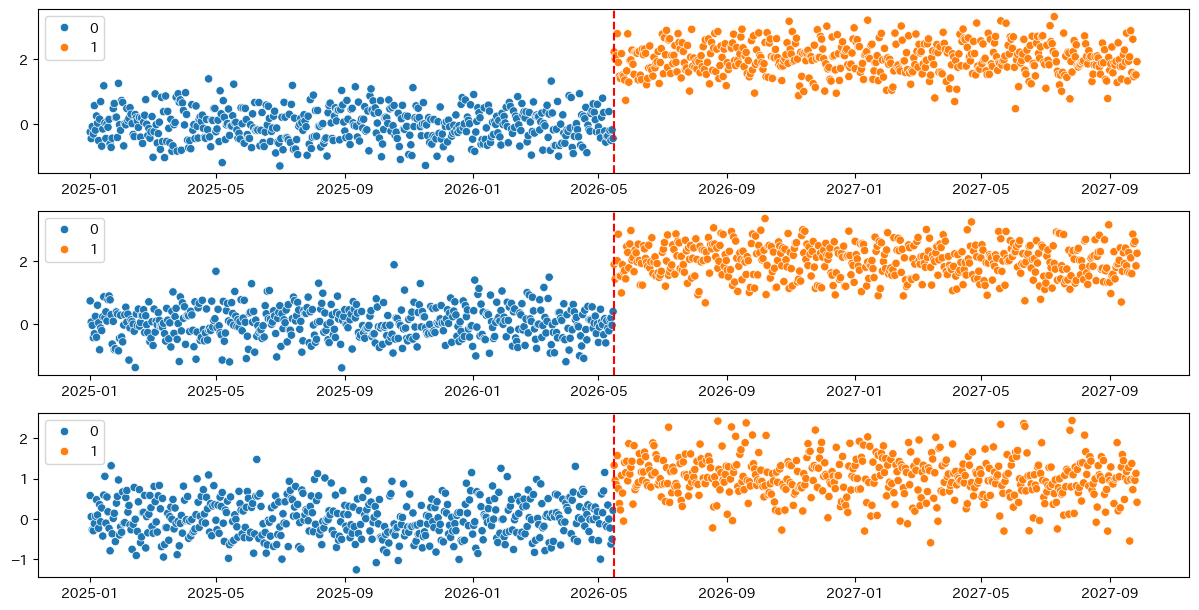

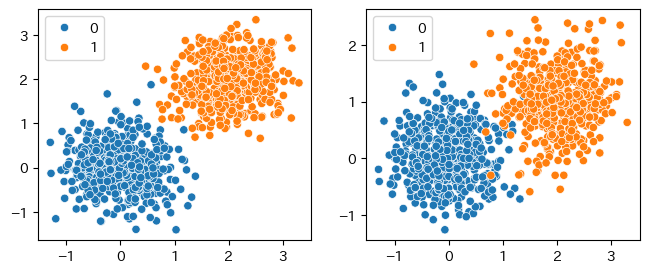

In [7]:
n_samples = 1000

make_array, label = make_blobs(n_samples=n_samples, centers=[[0, 0, 0], [2, 2, 1]], n_features=2, cluster_std=0.5)
df_make = pd.DataFrame(make_array)
df_make['LABEL'] = label
df_make = df_make.sort_values('LABEL')
df_make.index = pd.date_range(start='2025-01-01', periods=n_samples)
df_make = df_make

crustor_num, changing_point = gmm_detector(df_make.drop('LABEL', axis=1))

plt.figure(figsize=(12, 8))

for arg_idx in range(len(df_make.columns) - 1):
    plt.subplot(len(df_make.columns), 1, arg_idx+1)
    sns.scatterplot(x=df_make.index.values, y=df_make[arg_idx].values, hue=df_make['LABEL'].values)
    plt.axvline(changing_point, color='red', linestyle='dashed')


plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 3))

for arg_idx in range(len(df_make.columns) - 1):
    if arg_idx == 0: continue
    plt.subplot(1, len(df_make.columns)-1, arg_idx+1)
    sns.scatterplot(x=df_make[0].values, y=df_make[arg_idx].values, hue=df_make['LABEL'].values)

plt.show()